# Import Data

In [1]:
#Import Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
import xgboost as xgb


In [2]:
#Import data from local files
path_train = 'C:/Users/User/Downloads/dataGaia_AB_train.csv'
path_unknown = 'C:/Users/User/Downloads/dataGaia_AB_unknown.csv' 

data_train = pd.read_csv(path_train)
data_unknown = pd.read_csv(path_unknown)

# Preprocessing Training & Testing Data

In [3]:
##Remove 'ID', 'Unnamed: 0' from data_train
data_train = data_train.drop(columns = ['ID', 'Unnamed: 0', 'Source', 'pscol'], axis = 1)
data_unknown = data_unknown.drop(columns = ['ID', 'Unnamed: 0', 'Source', 'pscol'], axis = 1)

In [4]:
##Missing value imputation using median
features = ['GRVSmag', 'e_GRVSmag', 'Mass-Flame', 'Age-Flame', 'z-Flame', 'Lum-Flame']
for feature in features:
    median_t = data_train[feature].median()
    median_u = data_unknown[feature].median()

    data_train[feature][np.isnan(data_train[feature])] = median_t
    data_unknown[feature][np.isnan(data_unknown[feature])] = median_u


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148538 entries, 0 to 148537
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RA_ICRS     148538 non-null  float64
 1   DE_ICRS     148538 non-null  float64
 2   Plx         148538 non-null  float64
 3   PM          148538 non-null  float64
 4   pmRA        148538 non-null  float64
 5   pmDE        148538 non-null  float64
 6   Gmag        148538 non-null  float64
 7   e_Gmag      148538 non-null  float64
 8   BPmag       148538 non-null  float64
 9   e_BPmag     148538 non-null  float64
 10  RPmag       148538 non-null  float64
 11  e_RPmag     148538 non-null  float64
 12  GRVSmag     148538 non-null  float64
 13  e_GRVSmag   148538 non-null  float64
 14  BP-RP       148538 non-null  float64
 15  BP-G        148538 non-null  float64
 16  G-RP        148538 non-null  float64
 17  Teff        148538 non-null  float64
 18  Dist        148538 non-null  float64
 19  Ra

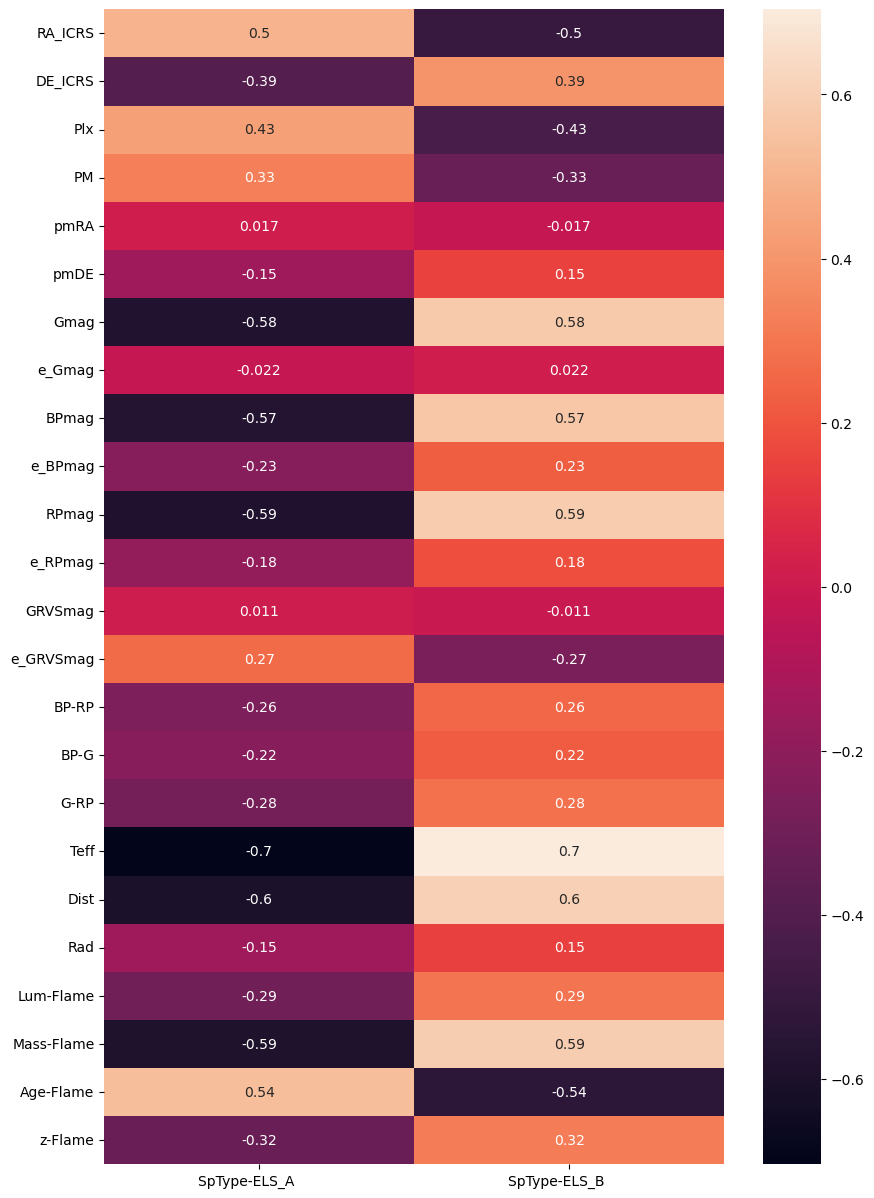

In [6]:
#Correlation of SPType-ELS with other variables 
data_with_onehot = pd.get_dummies(data_train, columns=['SpType-ELS'])
cat_cols = [col for col in data_with_onehot.columns if 'SpType-ELS' in col]
not_cat_cols = [col for col in data_with_onehot.columns if 'SpType-ELS' not in col]

targ_corr = data_with_onehot.corr()
plt.figure(figsize=(10, 15))
ax = sns.heatmap(targ_corr.loc[not_cat_cols, cat_cols], annot=True)
plt.show()

In [7]:
##Feature Selection With PCC
# Set a threshold
threshold = 0.4
PCC = abs(targ_corr.iloc[:, -1])[:-2]

# Filter out features with correlation below the threshold
PCC_index = []
for index in PCC.index:
    if PCC[index] >= threshold:
        PCC_index.append(index)
        

selected_data_PCC = data_train[PCC_index]
selected_data_PCC
unknown_PCC = data_unknown[PCC_index]

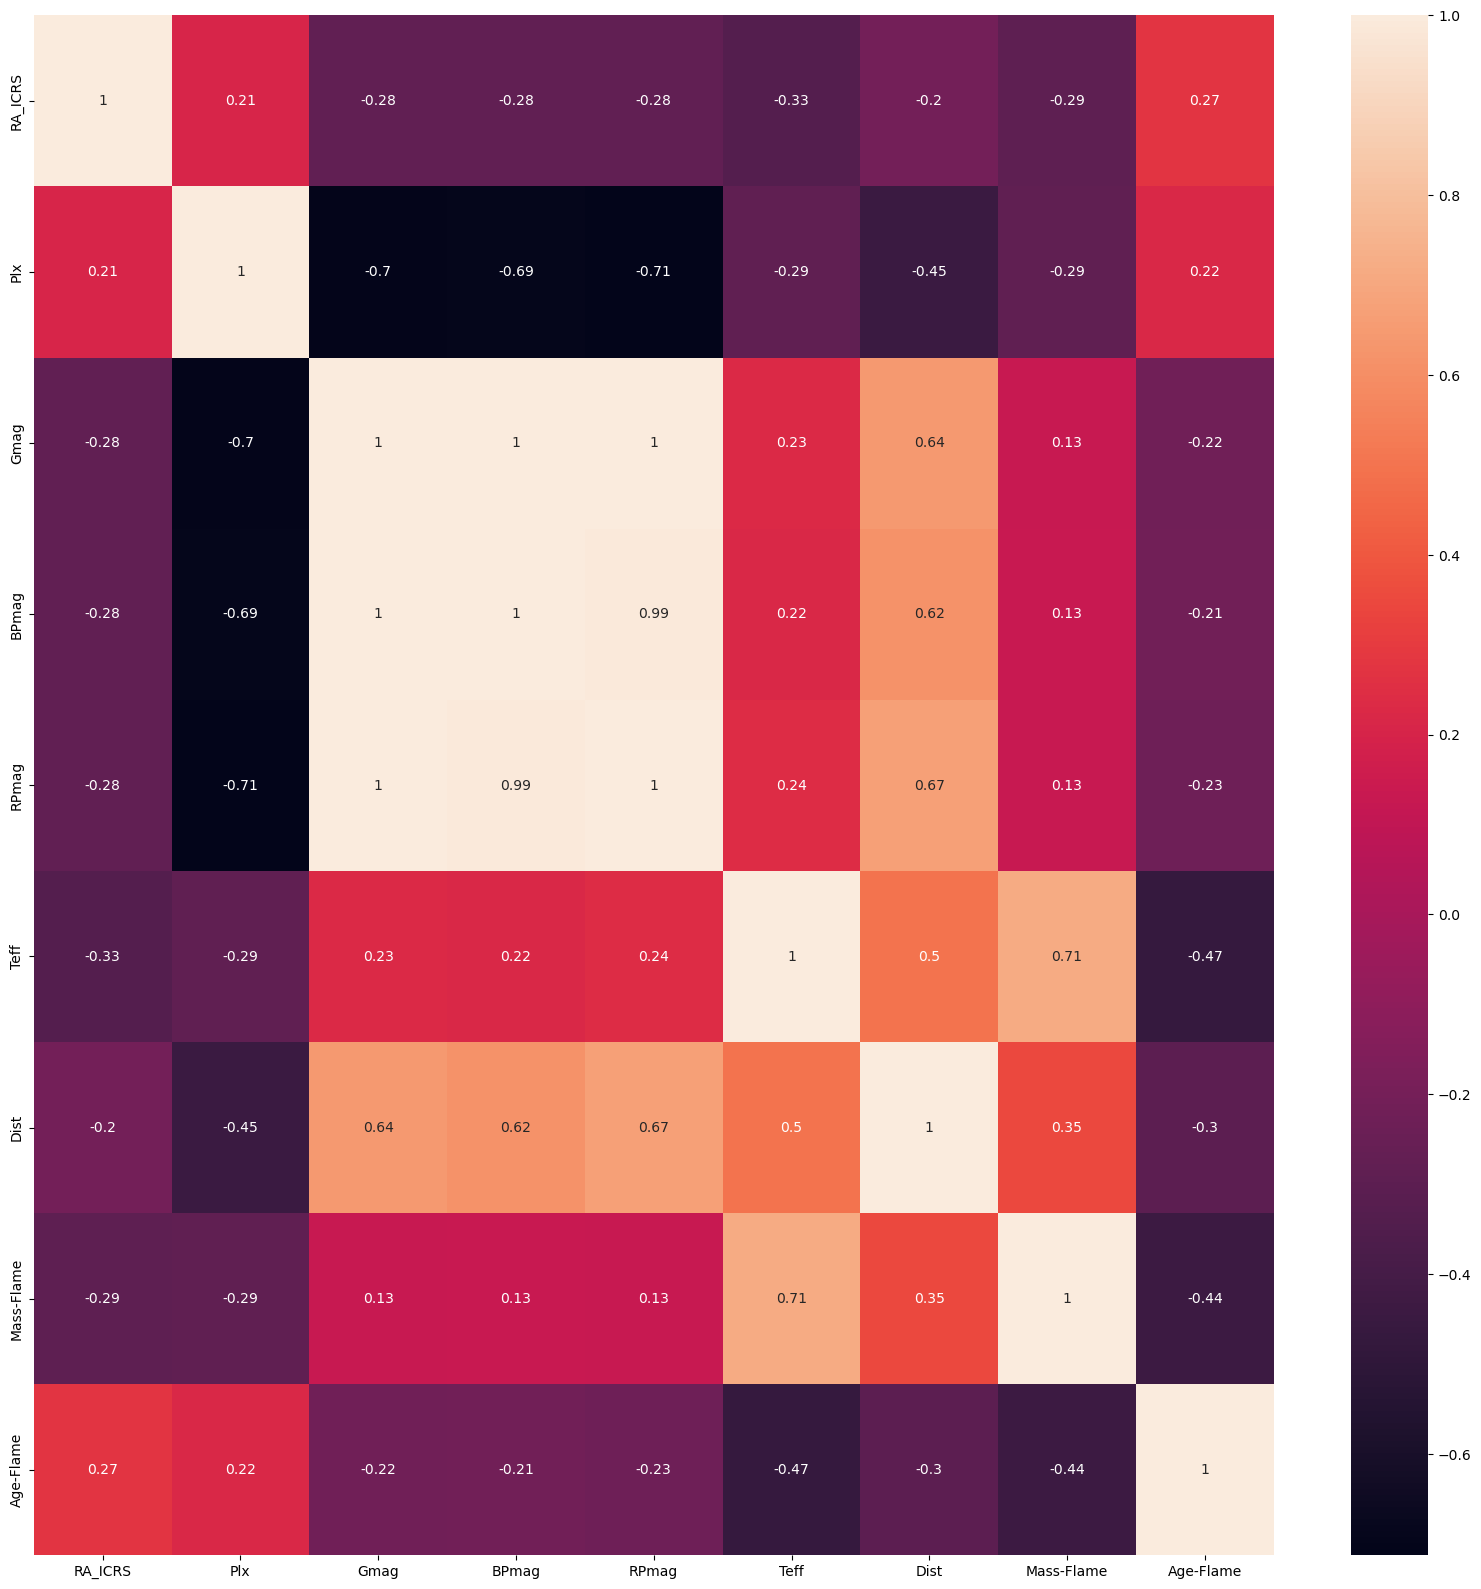

In [8]:
#Correlation matrix of all exlanatory variables
plt.figure(figsize = (20,20))
ax = sns.heatmap(selected_data_PCC.corr(), annot=True)
plt.show()

In [9]:
##Remove highly correlated columns to avoid multicollinearity
#calculate correlation matrix
corr_mat = selected_data_PCC.corr()

#identify highly correlated pairs
hi_corr_pair = []
threshold = 0.80

#remove one of the variable from  each highly correlated pair
for i in range(len(corr_mat.columns)):
    for j in range(i+1, len(corr_mat.columns)):
        if abs(corr_mat.iloc[i,j]) > threshold:
            hi_corr_pair.append((corr_mat.columns[i], corr_mat.columns[j]))
            
cols_to_drop = set()
for var1, var2 in hi_corr_pair:
    cols_to_drop.add(var2)
selected_data_PCC = selected_data_PCC.drop(columns = cols_to_drop)
unknown_PCC = unknown_PCC.drop(columns = cols_to_drop)

print(hi_corr_pair)

[('Gmag', 'BPmag'), ('Gmag', 'RPmag'), ('BPmag', 'RPmag')]


In [10]:
selected_data_PCC

,RA_ICRS,Plx,Gmag,Teff,Dist,Mass-Flame,Age-Flame
0,44.375187,1.8937,10.369156,9348.7,679.7121,2.157,0.336
1,42.959304,2.9732,10.038978,7520.7,339.8108,1.688,1.033
2,44.031079,2.2337,9.810181,7052.3,433.9715,1.923,1.124
3,45.463599,4.0179,8.163041,9982.8,251.2483,2.447,0.320
4,43.784164,11.6458,6.855547,7192.3,85.7073,1.647,1.288
...,...,...,...,...,...,...,...
148533,298.702986,0.1195,16.553267,11371.2,3914.1420,2.267,0.521
148534,298.733458,0.3125,12.213623,11368.6,3850.1494,3.714,0.521
148535,298.680593,0.7751,11.795012,10452.5,1470.3190,2.586,0.257
148536,298.331890,0.6775,14.703084,14737.3,1968.8260,2.267,0.521


In [11]:
##Define training and testing dataset

#Binarization
data_train['SpType-ELS'].replace({'A      ': 0, 'B      ': 1}, inplace = True)
#data_train.drop(columns = ['SpType-ELS', 'BI_SpType-ELS'], axis = 1)
X = selected_data_PCC
y = data_train['SpType-ELS']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)


# Classification Models - ANN

In [12]:
##Artificial Neural Networks
annCLF = MLPClassifier(hidden_layer_sizes=(4,), solver = 'adam', learning_rate_init = 0.001, 
                       random_state=100, max_iter=10000, early_stopping = False)
annCLF.fit(scaled_X_train, y_train)

MLPClassifier(hidden_layer_sizes=(4,), max_iter=10000, random_state=100)

[[15926   139]
 [   88 13555]]
Accuracy:  0.992358960549347
R2 Score:  0.9692313342873208


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


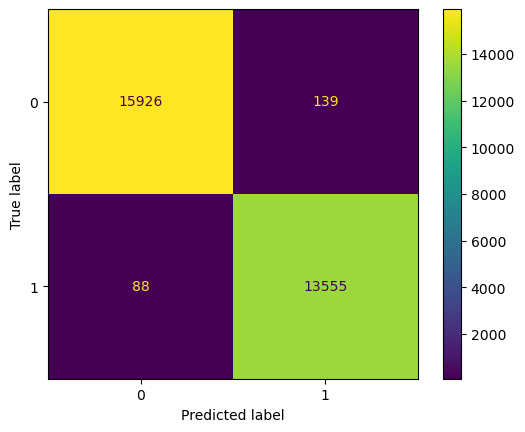

In [13]:
y_predann = annCLF.predict(scaled_X_test)

# Confusion matrix
# normalize="all" converts the raw numbers to proportions.
# Can be used in both of the following functions.
mat = confusion_matrix(y_test, y_predann)

print(mat)

print("Accuracy: ", annCLF.score(scaled_X_test, y_test))
print("R2 Score: ", r2_score(y_test, y_predann))

plot_confusion_matrix(annCLF, scaled_X_test, y_test)

In [14]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [15]:
##Cross validation
ann_accu_score = cross_val_score(annCLF, scaled_X, y, cv=5, scoring = 'accuracy')
ann_r2_score = cross_val_score(annCLF, scaled_X, y, cv=5, scoring='r2')

print("Accuracy: {:.4f}".format(ann_accu_score.mean()))
print("R2: {:.4f}".format(ann_r2_score.mean()))


Accuracy: 0.9855
R2: 0.9417


# Classification Models - Decision Tree

In [16]:
##Decision Tree
dtCLF = DecisionTreeClassifier (max_depth = 4, min_samples_split = 10, random_state=42)
dtCLF.fit(scaled_X_train, y_train)


DecisionTreeClassifier(max_depth=4, min_samples_split=10, random_state=42)

[[15849   216]
 [   81 13562]]
Accuracy:  0.9900026928773394
R2 Score:  0.959743199486054


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


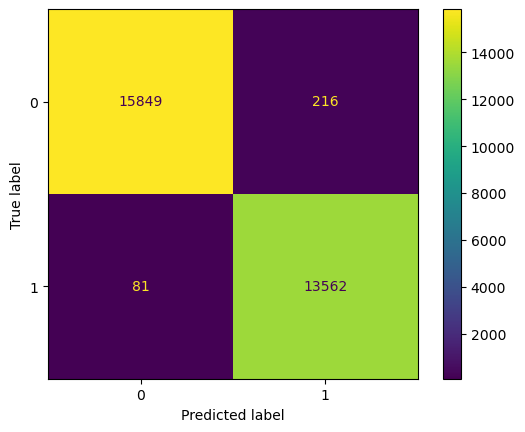

In [17]:
y_preddt = dtCLF.predict(scaled_X_test)

# Confusion matrix
# normalize="all" converts the raw numbers to proportions.
# Can be used in both of the following functions.
mat = confusion_matrix(y_test, y_preddt)
print(mat)
print("Accuracy: ", dtCLF.score(scaled_X_test, y_test))
print("R2 Score: ", r2_score(y_test, y_preddt))
plot_confusion_matrix(dtCLF, scaled_X_test, y_test);

In [18]:
#Cross validation
dt_accu_score = cross_val_score(dtCLF, scaled_X, y, cv=5, scoring = 'accuracy')
dt_r2_score = cross_val_score(dtCLF, scaled_X, y, cv=5, scoring='r2')

print("Accuracy: {:.4f}".format(dt_accu_score.mean()))
print("R2: {:.4f}".format(dt_r2_score.mean()))


Accuracy: 0.9498
R2: 0.7979


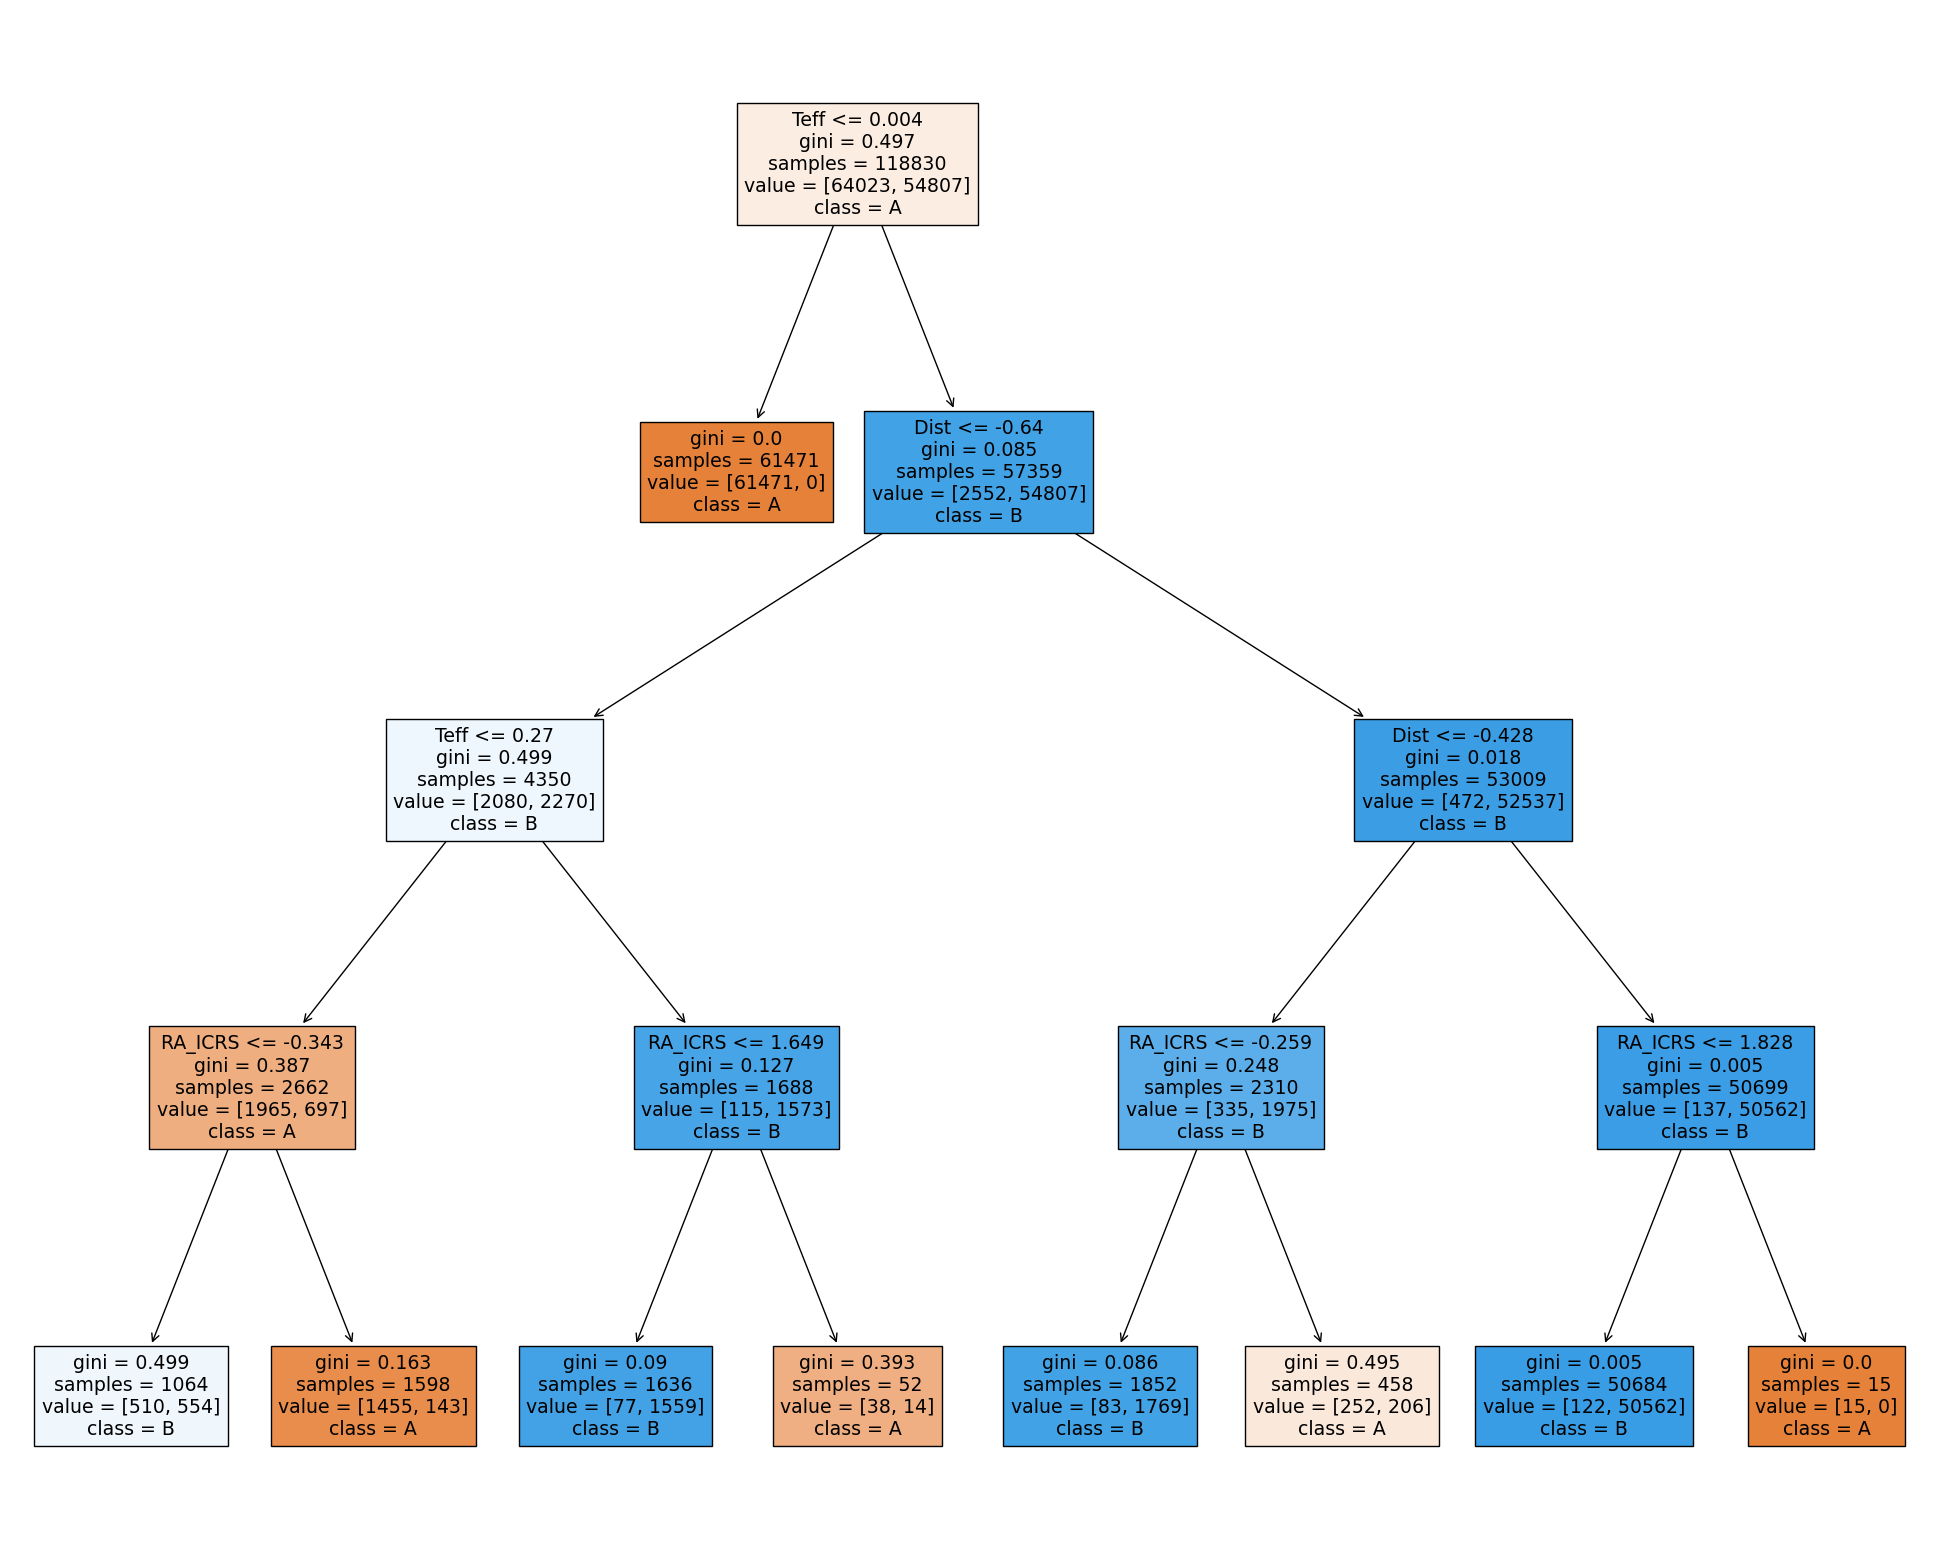

In [19]:
#Plot Decision Tree
features = selected_data_PCC.columns.tolist()
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtCLF, filled=True, feature_names=features, class_names = ['A','B'])

# Classification Models - Random Forest

In [20]:
##Random Forest
rfCLF = RandomForestClassifier (n_estimators = 250, max_depth = 5, 
                                min_samples_split = 10, random_state=42)
rfCLF.fit(scaled_X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=250,
                       random_state=42)

[[15945   120]
 [   66 13577]]
Accuracy:  0.9937390601858085
R2 Score:  0.9747886703852056


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


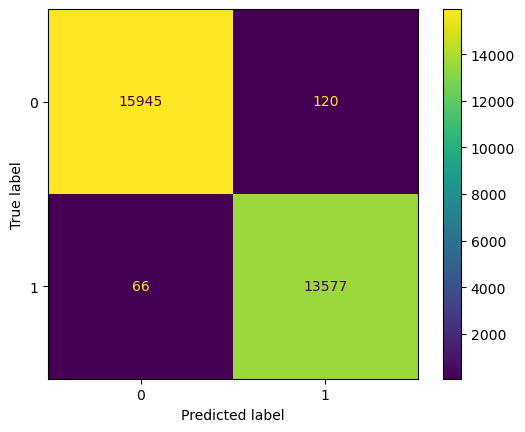

In [21]:
y_predrf = rfCLF.predict(scaled_X_test)

# Confusion matrix
# normalize="all" converts the raw numbers to proportions.
# Can be used in both of the following functions.
mat = confusion_matrix(y_test, y_predrf)
print(mat)
print("Accuracy: ", rfCLF.score(scaled_X_test, y_test))
print("R2 Score: ", r2_score(y_test, y_predrf))
plot_confusion_matrix(rfCLF, scaled_X_test, y_test);

In [22]:
#Cross validation
rf_accu_score = cross_val_score(rfCLF, scaled_X, y, cv=5, scoring = 'accuracy')
rf_r2_score = cross_val_score(rfCLF, scaled_X, y, cv=5, scoring='r2')

print("Accuracy: {:.4f}".format(rf_accu_score.mean()))
print("R2: {:.4f}".format(rf_r2_score.mean()))


Accuracy: 0.9533
R2: 0.8122


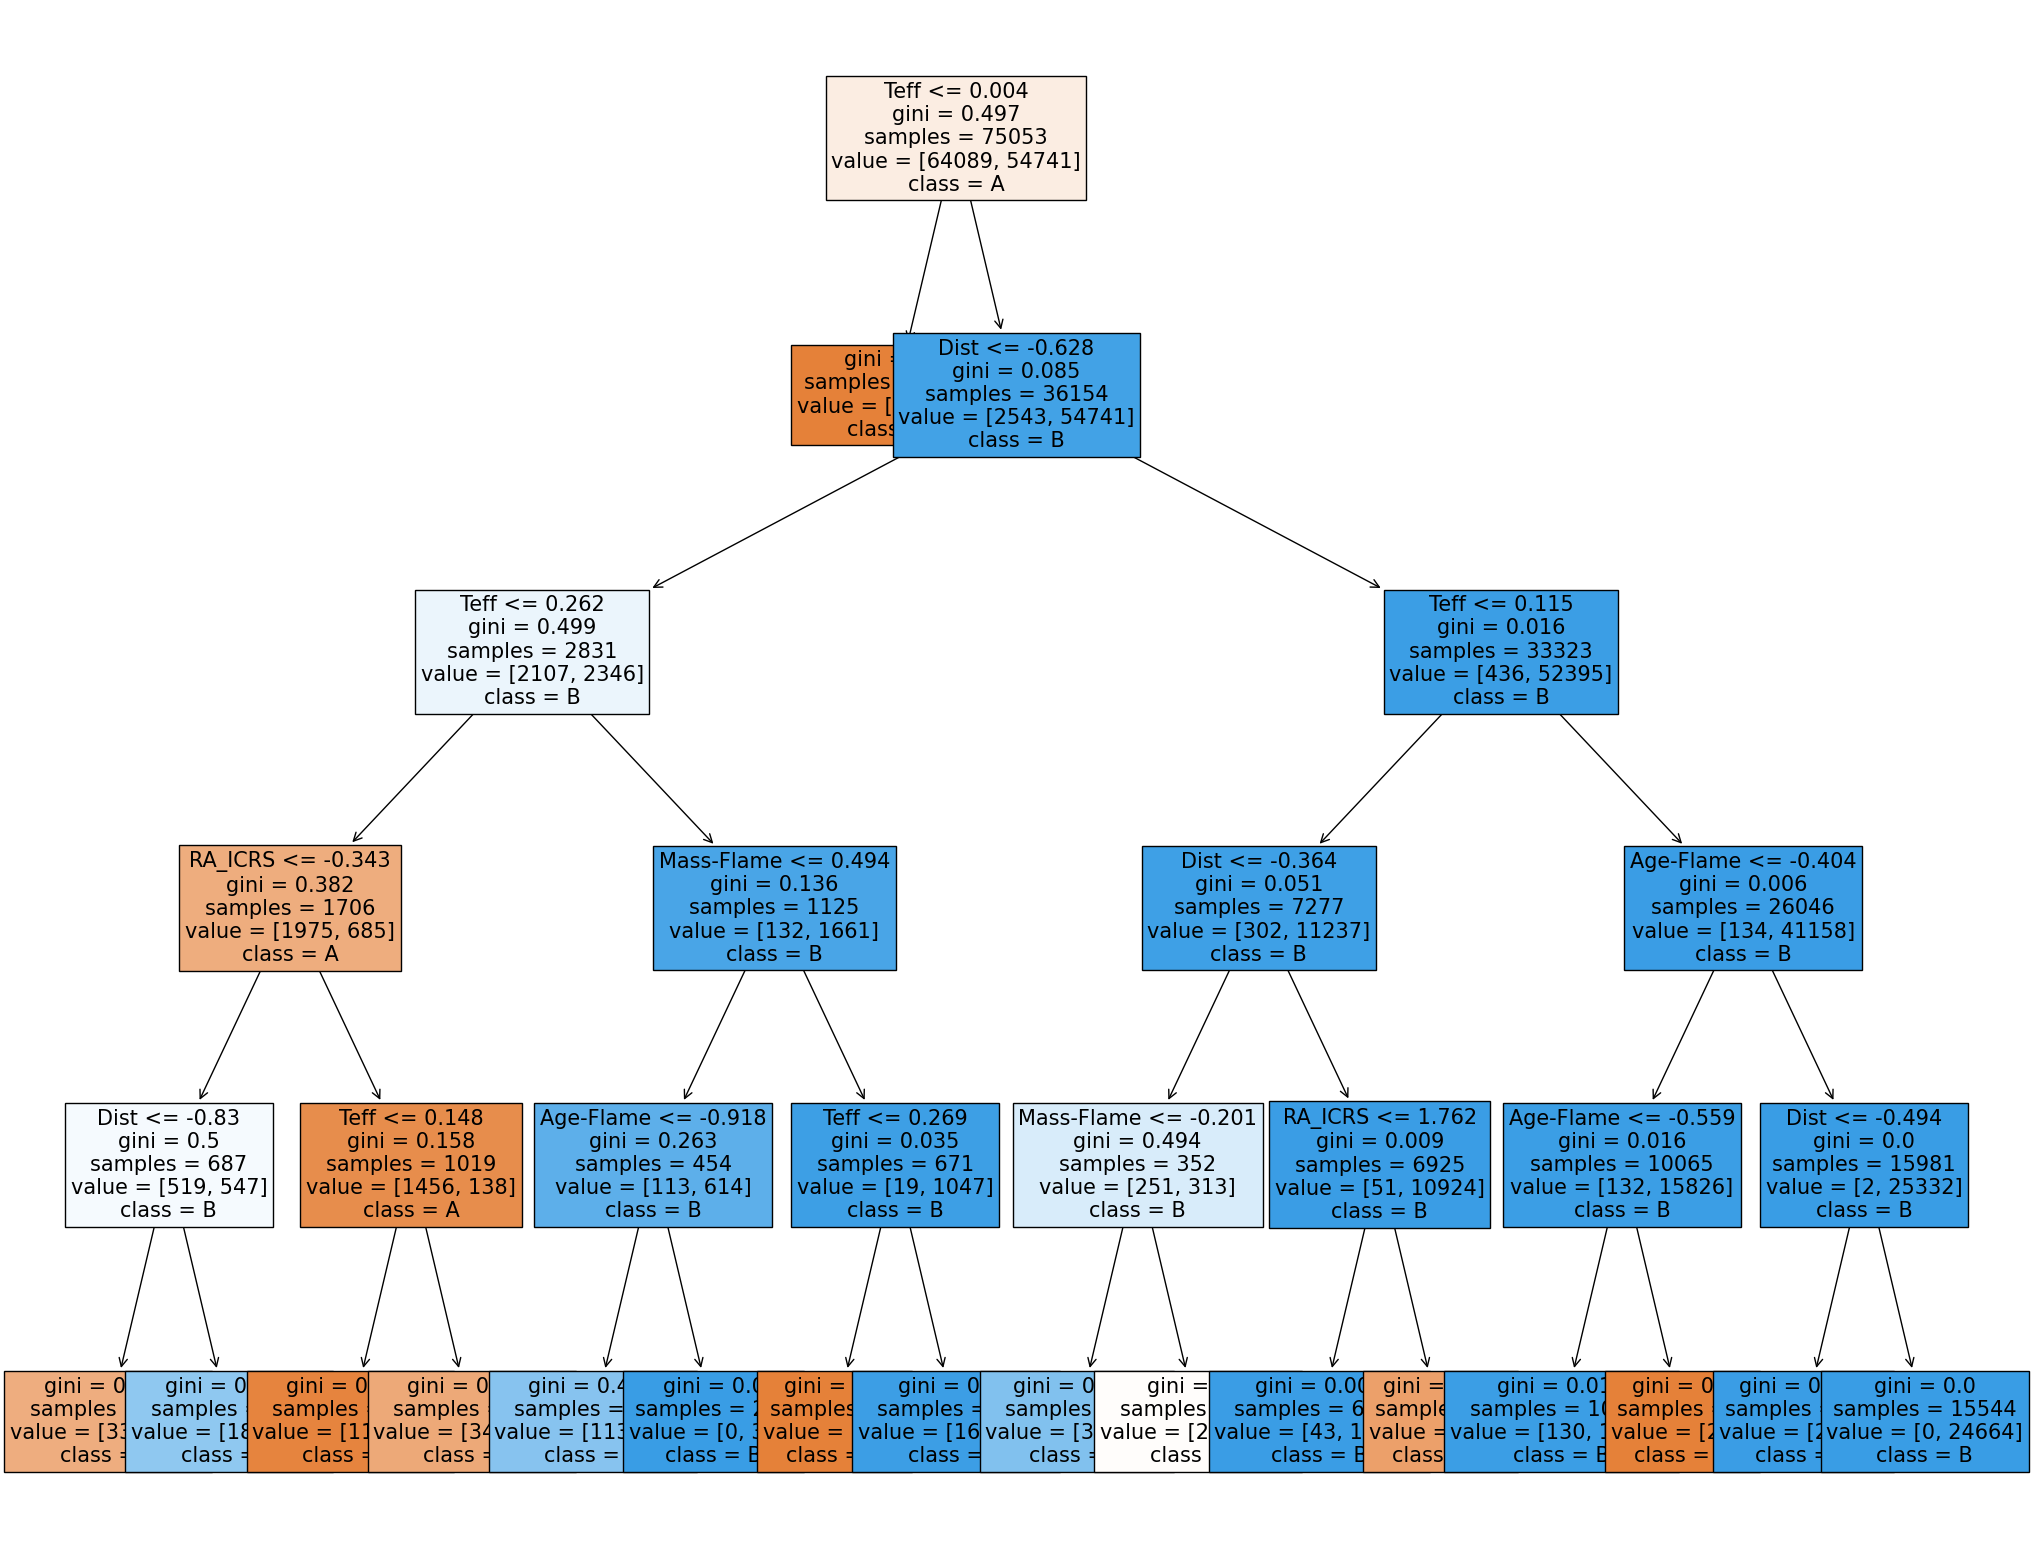

In [23]:
#Plot Tree
fig2 = plt.figure(figsize=(25,20))
_ = tree.plot_tree(rfCLF.estimators_[9], filled=True, fontsize = 15, feature_names=features, class_names = ['A','B'])

# Classification Models - KNN


In [24]:
knnCLF = KNeighborsClassifier(n_neighbors = 8)
knnCLF.fit(scaled_X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

[[15978    87]
 [  109 13534]]
Accuracy:  0.9934024505183789
R2 Score:  0.9734332225564531


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


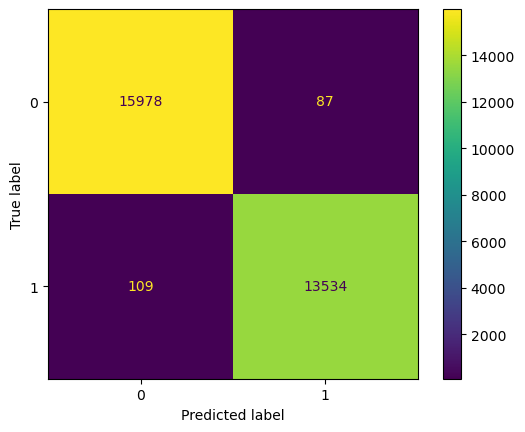

In [25]:
y_predknn = knnCLF.predict(scaled_X_test)

# Confusion matrix
# normalize="all" converts the raw numbers to proportions.
# Can be used in both of the following functions.
mat = confusion_matrix(y_test, y_predknn)
print(mat)
print("Accuracy: ", knnCLF.score(scaled_X_test, y_test))
print("R2 Score: ", r2_score(y_test, y_predknn))
plot_confusion_matrix(knnCLF, scaled_X_test, y_test);

In [26]:
#Cross validation
knn_accu_score = cross_val_score(knnCLF, scaled_X, y, cv=5, scoring = 'accuracy')
knn_r2_score = cross_val_score(knnCLF, scaled_X, y, cv=5, scoring='r2')

print("Accuracy: {:.4f}".format(knn_accu_score.mean()))
print("R2: {:.4f}".format(knn_r2_score.mean()))


Accuracy: 0.9702
R2: 0.8800


# Classification Models - Logistic Rgression


In [27]:
lrCLF = LogisticRegression()
lrCLF.fit(scaled_X_train, y_train)

LogisticRegression()

[[15932   133]
 [  113 13530]]
Accuracy:  0.9917194021812307
R2 Score:  0.9666559834126912


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


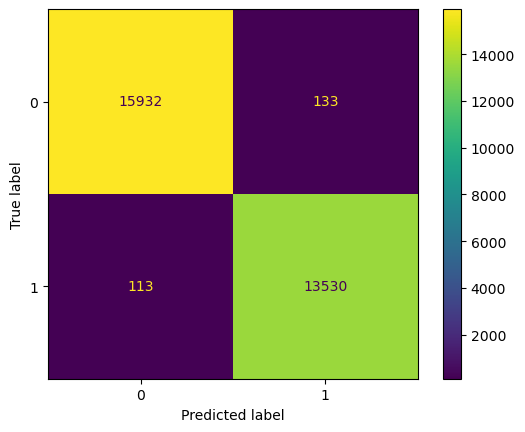

In [28]:
y_predlr = lrCLF.predict(scaled_X_test)

# Confusion matrix
# normalize="all" converts the raw numbers to proportions.
# Can be used in both of the following functions.
mat = confusion_matrix(y_test, y_predlr)
print(mat)
print("Accuracy: ", lrCLF.score(scaled_X_test, y_test))
print("R2 Score: ", r2_score(y_test, y_predlr))
plot_confusion_matrix(lrCLF, scaled_X_test, y_test);

In [29]:
#Cross validation
lr_accu_score = cross_val_score(lrCLF, scaled_X, y, cv=5, scoring = 'accuracy')
lr_r2_score = cross_val_score(lrCLF, scaled_X, y, cv=5, scoring='r2')

print("Accuracy: {:.4f}".format(lr_accu_score.mean()))
print("R2: {:.4f}".format(lr_r2_score.mean()))


Accuracy: 0.9870
R2: 0.9477


In [30]:
# Displaying the coefficients (betas) of all attributes
feature_names = X_train.columns.tolist()
print("Coefficients (betas):")
for feature_name, coef in zip(feature_names, lrCLF.coef_[0]):
    print(f"{feature_name}: {coef}")


Coefficients (betas):
RA_ICRS: -1.1986499638801902
Plx: 0.1685918894847138
Gmag: 1.226442318550525
Teff: 18.603490870597142
Dist: 3.010149401697766
Mass-Flame: 0.5148003433051753
Age-Flame: 0.9275023438364316


# Classification Models - SVM

In [31]:
# Initialize SVM classifier
svmCLF = SVC(kernel='rbf', random_state=42)

# Fit the SVR model to the training data
svmCLF.fit(scaled_X_train, y_train)

SVC(random_state=42)

[[15944   121]
 [  100 13543]]
Accuracy:  0.9925609263498048
R2 Score:  0.9700446029845722


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


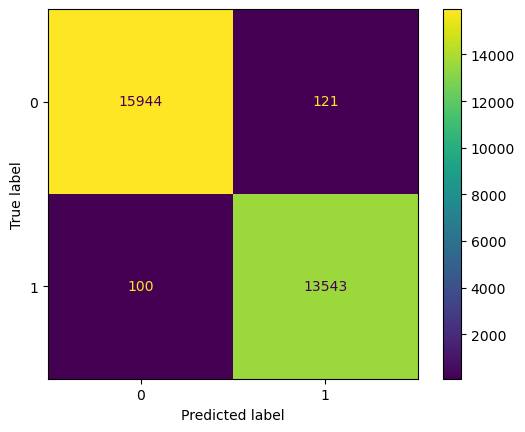

In [32]:
y_predsvm = svmCLF.predict(scaled_X_test)

# Confusion matrix
# normalize="all" converts the raw numbers to proportions.
# Can be used in both of the following functions.
mat = confusion_matrix(y_test, y_predsvm)
print(mat)
print("Accuracy: ", svmCLF.score(scaled_X_test, y_test))
print("R2 Score: ", r2_score(y_test, y_predsvm))
plot_confusion_matrix(svmCLF, scaled_X_test, y_test);

In [33]:
#Cross validation
svm_accu_score = cross_val_score(svmCLF, scaled_X, y, cv=5, scoring = 'accuracy')
svm_r2_score = cross_val_score(svmCLF, scaled_X, y, cv=5, scoring='r2')

print("Accuracy: {:.4f}".format(svm_accu_score.mean()))
print("R2: {:.4f}".format(svm_r2_score.mean()))


Accuracy: 0.9758
R2: 0.9027


# Classification Models - XGBoost

In [34]:
xgbCLF = xgb.XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=150,
    objective='binary:logistic')
xgbCLF.fit(scaled_X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

[[15971    94]
 [   47 13596]]
Accuracy:  0.995253803689242
R2 Score:  0.9808881856145913


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


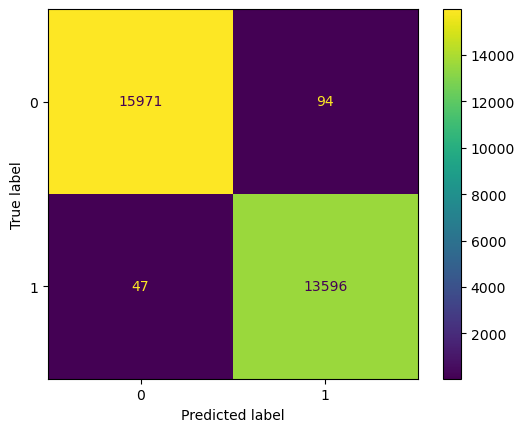

In [35]:
y_predxgb = xgbCLF.predict(scaled_X_test)

# Confusion matrix
# normalize="all" converts the raw numbers to proportions.
# Can be used in both of the following functions.
mat = confusion_matrix(y_test, y_predxgb)
print(mat)
print("Accuracy: ", xgbCLF.score(scaled_X_test, y_test))
print("R2 Score: ", r2_score(y_test, y_predxgb))
plot_confusion_matrix(xgbCLF, scaled_X_test, y_test);

In [36]:
#Cross validation
xgb_accu_score = cross_val_score(xgbCLF, scaled_X, y, cv=5, scoring = 'accuracy')
xgb_r2_score = cross_val_score(xgbCLF, scaled_X, y, cv=5, scoring='r2')

print("Accuracy: {:.4f}".format(xgb_accu_score.mean()))
print("R2: {:.4f}".format(xgb_r2_score.mean()))


Accuracy: 0.9567
R2: 0.8256


In [37]:
print(classification_report(y_test, y_predxgb))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     16065
           1       0.99      1.00      0.99     13643

    accuracy                           1.00     29708
   macro avg       1.00      1.00      1.00     29708
weighted avg       1.00      1.00      1.00     29708



(0.8, 1.01)

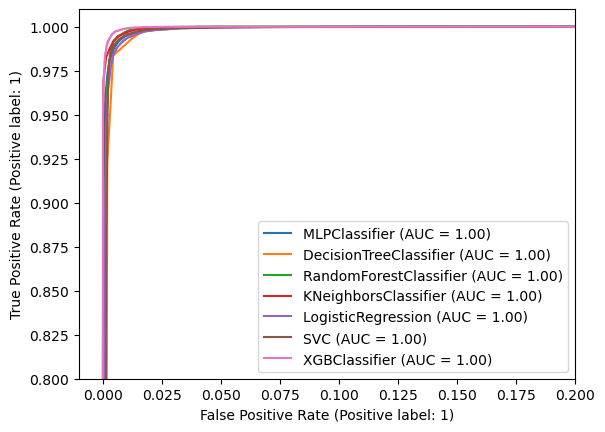

In [38]:
from sklearn.metrics import RocCurveDisplay
_,ax = plt.subplots()

models = [annCLF, dtCLF, rfCLF, knnCLF, lrCLF, svmCLF, xgbCLF]


for i in models:
    RocCurveDisplay.from_estimator(i, scaled_X, y, ax = ax)

ax.set_xlim(-0.01, 0.2)
ax.set_ylim(0.8, 1.01)

# Predict Unknown Data

In [39]:
#Select the best model for the daraset
scoreBoard = {
    'Classifier': ['annCLF', 'dtCLF', 'rfCLF', 'knnCLF', 'lrCLF', 'svmCLF', 'xgbCLF'],
    'HO_Accu': [annCLF.score(scaled_X_test, y_test), dtCLF.score(scaled_X_test, y_test), rfCLF.score(scaled_X_test, y_test), 
                 knnCLF.score(scaled_X_test, y_test), 
                 lrCLF.score(scaled_X_test, y_test), svmCLF.score(scaled_X_test, y_test), xgbCLF.score(scaled_X_test, y_test)],
    'HO_R2': [r2_score(y_test, y_predann), r2_score(y_test, y_preddt), r2_score(y_test, y_predrf), r2_score(y_test, y_predknn),
          r2_score(y_test, y_predlr), r2_score(y_test, y_predsvm), r2_score(y_test, y_predxgb)],
    'CrossVal_Accu': [ann_accu_score.mean(), dt_accu_score.mean(), rf_accu_score.mean(), knn_accu_score.mean(), lr_accu_score.mean(), 
                 svm_accu_score.mean(), xgb_accu_score.mean()],
    'CrossVal_R2': [ann_r2_score.mean(), dt_r2_score.mean(), rf_r2_score.mean(), knn_r2_score.mean(), lr_r2_score.mean(), 
                 svm_r2_score.mean(), xgb_r2_score.mean()]
}
scoreBoard_df = pd.DataFrame(scoreBoard)
scoreBoard_df

,Classifier,HO_Accu,HO_R2,CrossVal_Accu,CrossVal_R2
0,annCLF,0.992359,0.969231,0.985525,0.941744
1,dtCLF,0.990003,0.959743,0.949776,0.797865
2,rfCLF,0.993739,0.974789,0.953331,0.812172
3,knnCLF,0.993402,0.973433,0.970176,0.879966
4,lrCLF,0.991719,0.966656,0.987007,0.947705
5,svmCLF,0.992561,0.970045,0.975817,0.902672
6,xgbCLF,0.995254,0.980888,0.956657,0.825557


In [40]:
scaler = StandardScaler()
unknown_PCC_1 = scaler.fit_transform(unknown_PCC)

In [41]:
final_pred = annCLF.predict(unknown_PCC_1)

In [42]:
data_unknown = pd.read_csv(path_unknown)

In [43]:
df = pd.DataFrame({})

# Assign the array as a new column in the DataFrame
df['ID'] = data_unknown['ID']
df['SpType-ELS'] = final_pred

In [44]:
#Revert binarization
df['SpType-ELS'].replace({0: "A      ", 1: "B      "}, inplace = True)

In [45]:
#df.to_csv('C:/Users/User/Downloads/fda_a3_xgb_150.csv', index=False)